In [ ]:
from pandas_datareader import data
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import urllib.request, json
import os
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler

In [ ]:
df = pd.read_csv("General_Electric_Dataset.csv",delimiter=',',usecols=['Date','Open','High','Low','Close'])

In [ ]:
df = df.sort_values('Date')
df.head()

,Date,Open,High,Low,Close
0,1980-01-04,7.992788,8.193109,7.992788,8.173077
1,1980-01-07,8.173077,8.573718,8.112981,8.453526
2,1980-01-08,8.473558,8.754006,8.473558,8.754006
3,1980-01-09,8.754006,8.894231,8.653846,8.653846
4,1980-01-10,8.653846,8.754006,8.573718,8.693910


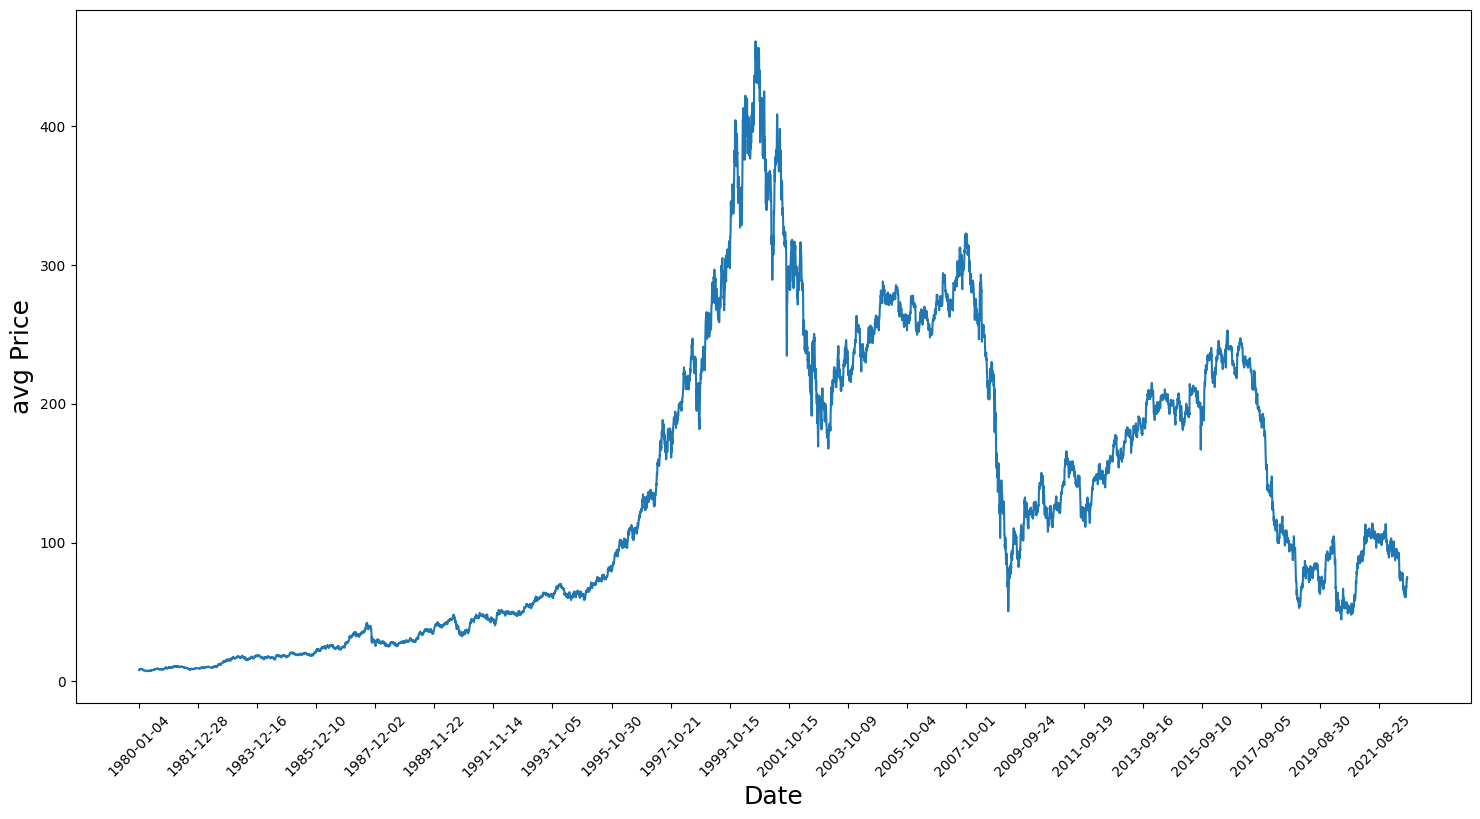

In [ ]:
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),(df['Low']+df['High'])/2.0)
plt.xticks(range(0,df.shape[0],500),df['Date'].loc[::500],rotation=45)
plt.xlabel('Date',fontsize=18)
plt.ylabel('avg Price',fontsize=18)
plt.show()

In [ ]:
# First calculate the average prices from the highest and lowest
high_prices = df.loc[:,'High'].to_numpy()
low_prices = df.loc[:,'Low'].to_numpy()
avg_prices = (high_prices+low_prices)/2.0

In [ ]:
train = avg_prices[:9500]
test = avg_prices[9500:]
len(avg_prices)

10737

In [ ]:
scaler = MinMaxScaler() #use mimaxscaler from scikitlearn to normalize data
train = train.reshape(-1,1)
test = test.reshape(-1,1)

In [ ]:
window_size = 2500
for x in range(0,train.shape[0] - window_size, window_size):
    scaler.fit(train[x:x+window_size,:])
    train[x:x+window_size,:] = scaler.transform(train[x:x+window_size,:])

scaler.fit(train[x+window_size:,:])
train[x+window_size:,:] = scaler.transform(train[x+window_size:,:])

In [ ]:
train = train.reshape(-1)

In [ ]:
test.shape

(1237, 1)

In [ ]:
test = scaler.transform(test).reshape(-1)

EMA Averaging

In [ ]:
EMA = 0.0 # keep EMA 0.0
ema2 = 0.1 # gamma is a variabe that can be multiplied with train
for i in range(len(train)):
  EMA = ema2*train[i] + (1-ema2)*EMA
  train[i] = EMA

In [ ]:
# Used for visualization and test purposes
if test.size == 0:
  test = test.reshape(-1)
all_avg_data = np.concatenate([train,test],axis=0)

In [ ]:
window_size = 100 # chose standard window size of 100
N = train.size
mse_err = []
_avg_pred = [] #create a list for average x, predictions and mse errors
_avg_x = []

for idx1 in range(window_size,N): #make a for loop where if the value is greater than size then use timedelta function for that 1 day

    if idx1 >= N:
        date = dt.datetime.strptime(k, '%Y-%m-%d').date() + dt.timedelta(days=1)
    else:
        date = df.loc[idx1,'Date']  #if not just find that value in the dataframe for the data and put it in date

    _avg_pred.append(np.mean(train[idx1-window_size:idx1])) #Keep apending values into into the lists
    mse_err.append((_avg_pred[-1]-train[idx1])**2)   #calculate mse errors
    _avg_x.append(date) #this is the x train for averages we will use to train

print('MSE error for standard averaging: %.5f'%(0.5*np.mean(mse_err)))

MSE error for standard averaging: 0.00247


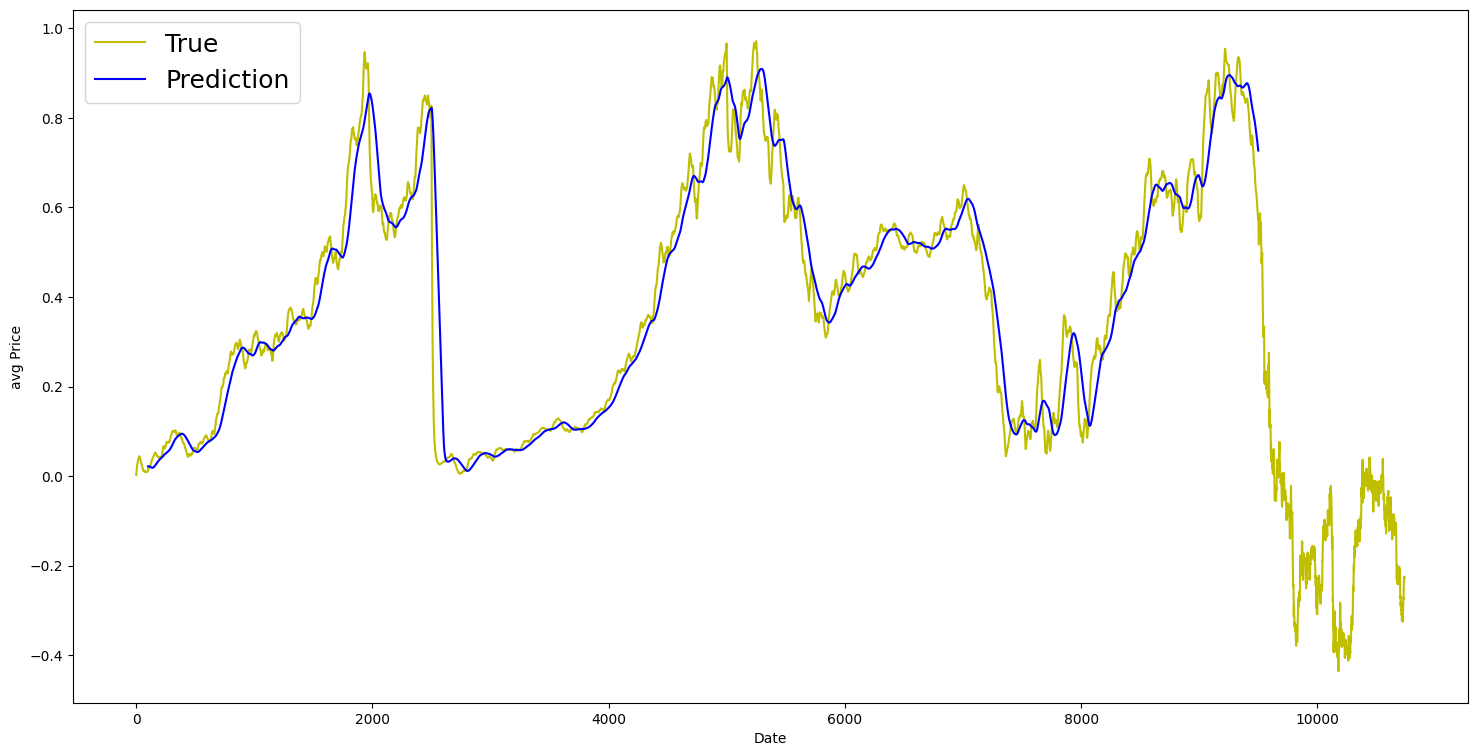

In [ ]:
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),all_avg_data,color='y',label='True')
plt.plot(range(window_size,N),_avg_pred,color='b',label='Prediction')
plt.xlabel('Date')
plt.ylabel('avg Price')
plt.legend(fontsize=18)
plt.show()

In [ ]:
window_size = 100
N = train.size
mse_err = []
_avg_predictions_run = []
_avg_x_run = []



running_mean = 0.0 #the mean tat is calculates
_avg_predictions_run.append(running_mean)

decay = 0.5 # use this to average the running mean again;

for idx1 in range(1,N): #range from 1 to N-1

    running_mean = running_mean*decay + (1.0-decay)*train[idx1-1] #the remaining prob multiplied by the train sets data points
    _avg_predictions_run.append(running_mean)
    mse_err.append((_avg_predictions_run[-1]-train[idx1])**2) #make mse error with the help of train set
    _avg_x_run.append(date) #append the dates into the list

print('MSE error for EMA averaging: %.5f'%(0.5*np.mean(mse_err))) #Calculate MSE

MSE error for EMA averaging: 0.00002


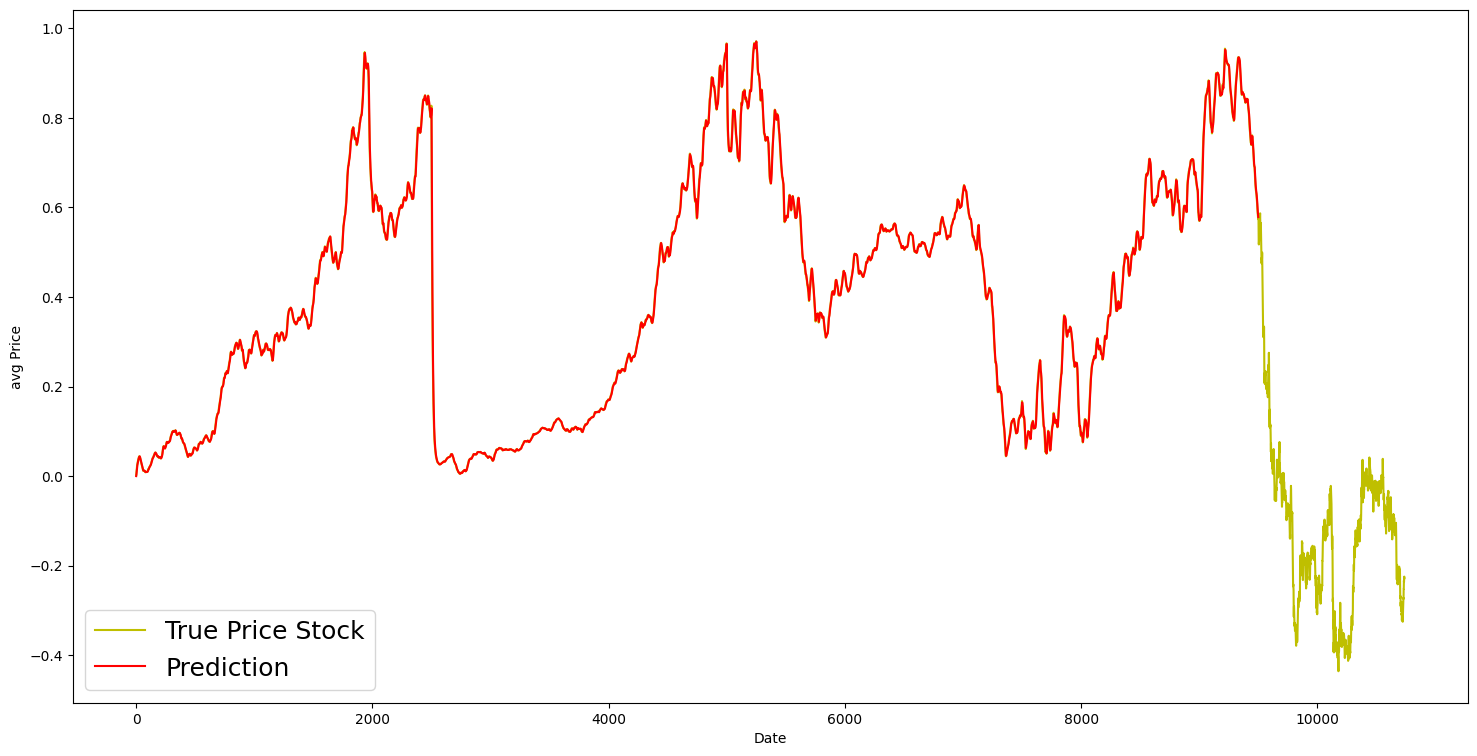

In [ ]:
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),all_avg_data,color='y',label='True Price Stock')
plt.plot(range(0,N),_avg_predictions_run,color='r', label='Prediction')
plt.xlabel('Date')
plt.ylabel('avg Price')
plt.legend(fontsize=18)
plt.show()

# LSTM

In [ ]:
class Generator(object):

    def __init__(self,prices,batch_size,num_unroll): #helps to generate data
        self._prices = prices
        self._prices_length = len(self._prices) - num_unroll
        self._batch_size = batch_size
        self._num_unroll = num_unroll
        self._segments = self._prices_length //self._batch_size
        self._cursor = [offset * self._segments for offset in range(self._batch_size)]

    def next(self):   #which will output a set of num_unrollings batches of input data obtained sequentially, where a batch of data is of size [batch_size, 1].

        batch_data = np.zeros((self._batch_size),dtype=np.float32)  #Then each batch of input data will have a corresponding output batch of data.
        batch_labels = np.zeros((self._batch_size),dtype=np.float32)

        for b in range(self._batch_size):   #create batches
            if self._cursor[b]+1>=self._prices_length:
                self._cursor[b] = np.random.randint(0,(b+1)*self._segments)

            batch_data[b] = self._prices[self._cursor[b]]
            batch_labels[b]= self._prices[self._cursor[b]+np.random.randint(1,5)]

            self._cursor[b] = (self._cursor[b]+1)%self._prices_length

        return batch_data,batch_labels

    def unroll(self):   #roll out the batches generated in form of data and labels

        unroll_data,unroll_labels = [],[]
        init_data, init_label = None,None
        for ui in range(self._num_unroll):

            data, labels = self.next()

            unroll_data.append(data)
            unroll_labels.append(labels)

        return unroll_data, unroll_labels

    def reset_indices(self): #get prices length
        for b in range(self._batch_size):
            self._cursor[b] = np.random.randint(0,min((b+1)*self._segments,self._prices_length-1))



dg = Generator(train,5,5)
u_data, u_labels = dg.unroll()

for ui,(dat,lbl) in enumerate(zip(u_data,u_labels)):
    print('\n\nUnrolled index %d'%ui)
    dat_ind = dat
    lbl_ind = lbl
    print('\tInputs: ',dat )
    print('\n\tOutput:',lbl)



Unrolled index 0
	Inputs:  [0.00263459 0.80082154 0.11302206 0.39504498 0.10888953]

	Output: [0.00572165 0.80332124 0.11508749 0.41621694 0.10732862]


Unrolled index 1
	Inputs:  [0.00572165 0.8012663  0.11364001 0.40073907 0.10619903]

	Output: [0.00927319 0.80550116 0.11450541 0.4165734  0.10563485]


Unrolled index 2
	Inputs:  [0.00927319 0.8024684  0.11450541 0.40683737 0.10563485]

	Output: [0.01590189 0.80627984 0.11566757 0.41621694 0.10784543]


Unrolled index 3
	Inputs:  [0.01292778 0.80332124 0.11508749 0.41335562 0.10640063]

	Output: [0.01590189 0.80550116 0.11543187 0.4165734  0.10784543]


Unrolled index 4
	Inputs:  [0.01590189 0.8037451  0.11566757 0.41621694 0.10732862]

	Output: [0.02101913 0.80627984 0.11588041 0.41861674 0.10897385]


In [ ]:
D = 1 # Dimensionality of the data. Since our data is 1-D this would be 1
num_unrollings = 50 # Number of time steps you look into the future.
batch_size = 500 # Number of samples in a batch
num_nodes = [200,200,150] # Number of hidden nodes in each layer of the deep LSTM stack we're using
n_layers = len(num_nodes) # number of layers
dropout = 0.2 # dropout amount


tf.compat.v1.reset_default_graph() # This is important in case you run this multiple times


In [ ]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
train_inputs, train_outputs = [],[]

# You unroll the input over time defining placeholders for each time step
for ui in range(num_unrollings):
    train_inputs.append(tf.compat.v1.placeholder(tf.float32, shape=[batch_size,D],name='train_inputs_%d'%ui))
    train_outputs.append(tf.compat.v1.placeholder(tf.float32, shape=[batch_size,1], name = 'train_outputs_%d'%ui))

Instructions for updating:
non-resource variables are not supported in the long term


In [ ]:
import tensorflow as tf

# Create LSTM cells using tf.keras.layers.LSTMCell
lstm_cells = [
    tf.keras.layers.LSTMCell(units=num_nodes[li],
                            kernel_initializer=tf.keras.initializers.GlorotUniform(),
                            dropout=dropout)  # Apply dropout directly to LSTMCell
    for li in range(n_layers)
]

# Create a MultiRNNCell (stack of RNN layers) using tf.keras.layers.RNN
multi_cell = tf.keras.layers.RNN(lstm_cells, return_sequences=False)

# Create the weights and biases using tf.Variable
w = tf.Variable(tf.keras.initializers.GlorotUniform()(shape=[num_nodes[-1], 1]), name='w')
b = tf.Variable(tf.random.uniform([1], -0.1, 0.1), name='b')

# Now you can define the model, loss function, and optimizer

In [ ]:
# Create cell state and hidden state variables to maintain the state of the LSTM
a1, b1 = [],[]
initial_state = []
for li in range(n_layers):
    a1.append(tf.zeros([batch_size, num_nodes[li]], dtype=tf.float32))
    b1.append(tf.zeros([batch_size, num_nodes[li]], dtype=tf.float32))
    initial_state.append((a1[li], b1[li]))  # Using tuple to define state

# Do several tensor transofmations, because the function dynamic_rnn requires the output to be of
# a specific format.
all_inputs = tf.concat([tf.expand_dims(t,0) for t in train_inputs],axis=0)

# all_outputs is [seq_length, batch_size, num_nodes]
'''all_lstm_outputs, state = tf.nn.dynamic_rnn(
    drop_multi_cell, all_inputs, initial_state=tuple(initial_state),
    time_major = True, dtype=tf.float32)

all_lstm_outputs = tf.reshape(all_lstm_outputs, [batch_size*num_unrollings,num_nodes[-1]])

all_outputs = tf.nn.xw_plus_b(all_lstm_outputs,w,b)

split_outputs = tf.split(all_outputs,num_unrollings,axis=0)
'''
lstm_layers = [
    tf.keras.layers.LSTM(num_nodes[li], return_sequences=True, dropout=dropout, recurrent_dropout=dropout)
    for li in range(n_layers)
]

multi_cell = tf.keras.Sequential(lstm_layers)
all_lstm_outputs = multi_cell(all_inputs)
all_lstm_outputs_flattened = tf.reshape(all_lstm_outputs, [batch_size * num_unrollings, num_nodes[-1]])
all_outputs = tf.add(tf.matmul(all_lstm_outputs_flattened, w), b)
split_outputs = tf.split(all_outputs, num_unrollings, axis=0)

In [ ]:
# When calculating the loss you need to be careful about the exact form, because you calculate
# loss of all the unrolled steps at the same time
# Therefore, take the mean error or each batch and get the sum of that over all the unrolled steps
print('Loss for the input train while converting prices into movements')
loss = 0.0
for ui in range(num_unrollings):
  loss += tf.reduce_mean(0.5*(split_outputs[ui]-train_outputs[ui])**2)

print('Learning rate decay operations')
global_step = tf.Variable(0, trainable=False)
# inc_gstep = tf.assign(global_step,global_step + 1)

tf_learning_rate = tf.compat.v1.placeholder(shape=None,dtype=tf.float32)
tf_min_learning_rate = tf.compat.v1.placeholder(shape=None,dtype=tf.float32)


learning_rate_decay = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=tf_learning_rate,
    decay_steps=1,
    decay_rate=0.5,
    staircase=True
)

learning_rate_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=tf_min_learning_rate,
    decay_steps=1,
    decay_rate=0.5,
    staircase=True
)
# learning_rate = tf.maximum(learning_rate_decay(global_step), tf_min_learning_rate)

# Optimizer.
print('TF Optimization operations')
optimizer = tf.keras.optimizers.Adam(learning_rate_schedule)
'''
gradients, v = zip(*optimizer.compute_gradients(loss))
gradients, _ =  tf.clip_by_global_norm(gradients, 5.0)
optimizer = optimizer.apply_gradients(
    zip(gradients, v))
'''

# ... (previous code)

with tf.GradientTape() as tape:
    # Model definition (lstm_layers, multi_cell, etc.) should be inside this block
    lstm_layers = [
        tf.keras.layers.LSTM(num_nodes[li], return_sequences=True, dropout=dropout, recurrent_dropout=dropout)
        for li in range(n_layers)
    ]

    multi_cell = tf.keras.Sequential(lstm_layers)
    all_lstm_outputs = multi_cell(all_inputs)
    all_lstm_outputs_flattened = tf.reshape(all_lstm_outputs, [batch_size * num_unrollings, num_nodes[-1]])
    all_outputs = tf.add(tf.matmul(all_lstm_outputs_flattened, w), b)  # Assuming w and b are defined before this block
    split_outputs = tf.split(all_outputs, num_unrollings, axis=0)

    # Calculate the loss within the GradientTape context
    loss = 0.0
    for ui in range(num_unrollings):
        loss += tf.reduce_mean(0.5 * (split_outputs[ui] - train_outputs[ui]) ** 2)

# Get gradients
gradients = tape.gradient(loss, tape.watched_variables())

# Clip gradients
gradients, _ = tf.clip_by_global_norm(gradients, 5.0)

# Apply gradients
optimizer.apply_gradients(zip(gradients, tape.watched_variables()))


Loss for the input train while converting prices into movements
Learning rate decay operations
TF Optimization operations


/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:678: UserWarning: Gradients do not exist for variables ['sequential_3/lstm_12/lstm_cell/kernel:0', 'sequential_3/lstm_12/lstm_cell/recurrent_kernel:0', 'sequential_3/lstm_12/lstm_cell/bias:0', 'sequential_3/lstm_13/lstm_cell/kernel:0', 'sequential_3/lstm_13/lstm_cell/recurrent_kernel:0', 'sequential_3/lstm_13/lstm_cell/bias:0', 'sequential_3/lstm_14/lstm_cell/kernel:0', 'sequential_3/lstm_14/lstm_cell/recurrent_kernel:0', 'sequential_3/lstm_14/lstm_cell/bias:0'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


<KerasVariable shape=(), dtype=int64, path=adam/iteration>